<a href="https://colab.research.google.com/github/boyila/124ofai_alphaml_sep4_2023/blob/main/object_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Recognition with SIFT and SVM

 basic object recognition pipeline using the SIFT (Scale-Invariant Feature Transform) descriptor for feature extraction and the Support Vector Machine (SVM) for classification.



## 1. Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, transform
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


## 2. Data Preprocessing

Images come in various sizes and color schemes (e.g., RGB, grayscale). For consistency and to simplify our pipeline, we'll convert all images to grayscale and resize them to a standard size.   
    
    

In [2]:
def preprocess_images(images):
#  Convert images to grayscale (if they aren't) and resize them to 128x128.
    processed_images = []
    for img in images:
        if len(img.shape) == 2 or img.shape[2] == 1:
            img_gray = img  # Image is already grayscale
        else:
            img_gray = color.rgb2gray(img)
        img_resized = transform.resize(img_gray, (128, 128))
        processed_images.append(img_resized)
    return np.array(processed_images)





## 3. Load the dataset



In [3]:
# Load sample images and preprocess them
images = [data.camera(), data.coins(), data.horse(), data.moon()]
labels = ['camera', 'coins', 'horse', 'moon']
images_processed = preprocess_images(images)



# Displaying Preprocessed Images

Visualize our preprocessed images to understand the changes:


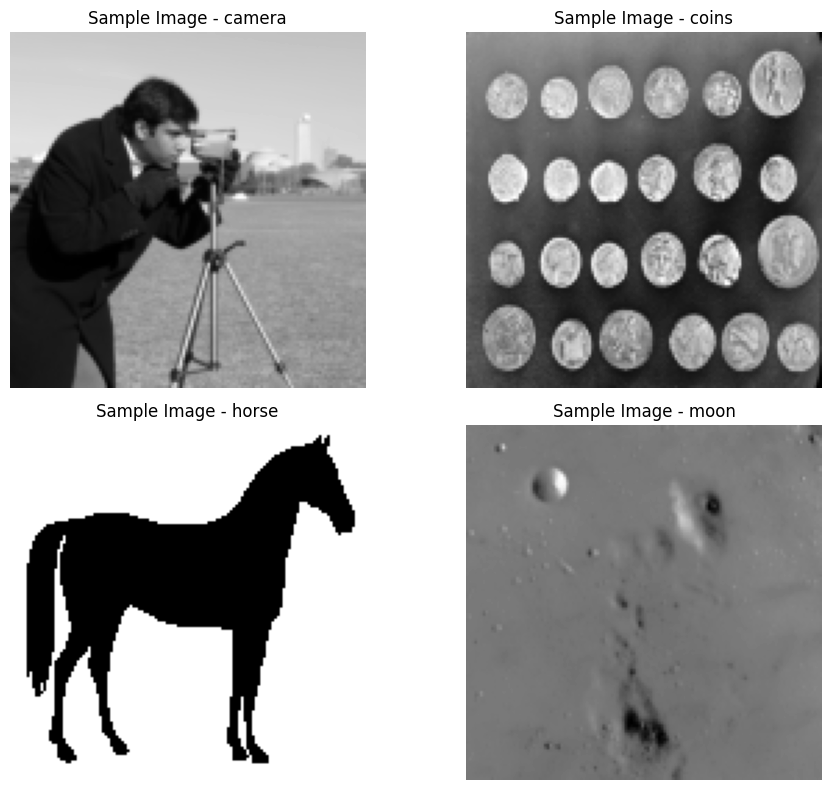

In [4]:

plt.figure(figsize=(10, 8))
for i, img in enumerate(images_processed):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample Image - {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Displaying processed Images


In [5]:
# Load and process an image
image = data.coins()
if len(image.shape) == 3 and image.shape[2] == 3:  # Check if the image is RGB
    image = color.rgb2gray(image)
image = (image * 255).astype(np.uint8)  # Convert to 8-bit unsigned int

## 3. Feature Extraction with SIFT

SIFT is a method to detect distinctive keypoints in images. These keypoints are invariant to image scale, rotation, and partially invariant to change in illumination and 3D camera viewpoint. In simple terms, these are points in the image that stand out and can be consistently recognized under various conditions.

Images are made of pixels, but not every pixel is valuable for our recognition task. So, we need to extract significant features that describe the content of the image. We use the **Scale-Invariant Feature Transform (SIFT)** method for this purpose.

**SIFT Steps:**
1. Detection of keypoints in the image.
2. Creation of a descriptor for each keypoint that captures its local appearance.

These descriptors will then act as our input features for the SVM classifier.


In [6]:
def extract_sift_features(images, num_keypoints=20):
    # Extract SIFT features from each image and normalize the number of keypoints.
    sift = cv2.SIFT_create(nfeatures=num_keypoints)
    descriptors_list = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)  # Convert to uint8 format for SIFT
        keypoints, des = sift.detectAndCompute(img_uint8, None)
        if des is not None:
            # If less than desired keypoints are detected, we'll pad with zeros Ensure descriptor size consistency across images
            if des.shape[0] < num_keypoints:
                padding = np.zeros((num_keypoints - des.shape[0], 128))
                des = np.vstack((des, padding))
            descriptors_list.append(des)


            # Displaying the keypoints on the image
            img_with_keypoints = cv2.drawKeypoints(img_uint8, keypoints, np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_with_keypoints)
            plt.title("SIFT Keypoints")
            plt.axis('off')
            plt.show()


    return np.array(descriptors_list, dtype=object)






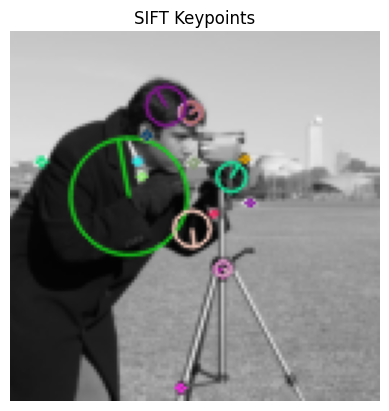

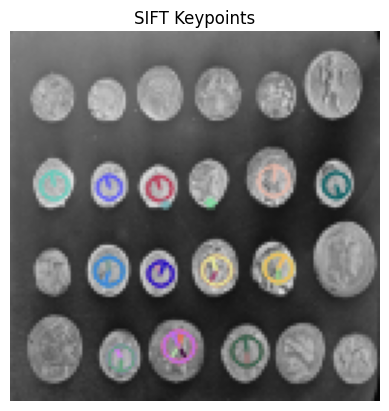

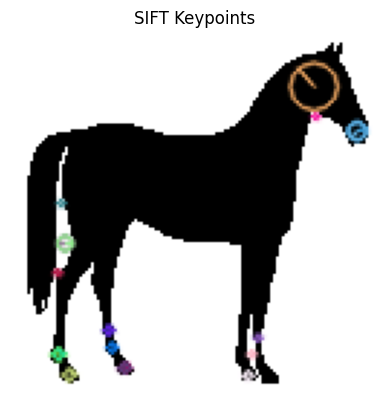

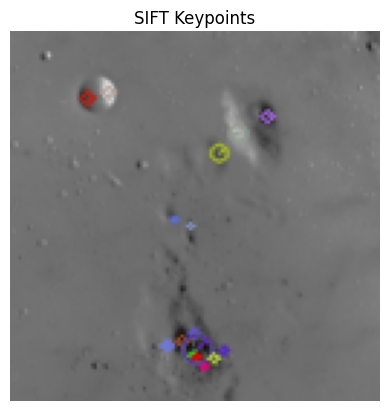

Feature is longer (2944) than expected max_length (2560).


In [8]:

def flatten_features(features, max_keypoints=20):
    """
    Flatten and pad the features to ensure they have a consistent shape.
    """
    flattened_features = []
    max_length = max_keypoints * 128  # 128 is the SIFT descriptor length

    for feature in features:
        # Ensure padding length is never negative
        padding_len = max(0, max_keypoints - feature.shape[0])
        padded_feature = np.pad(feature, ((0, padding_len), (0, 0)), mode='constant')
        flattened_feature = padded_feature.flatten()

        # Ensure all features have the same length
        extra_padding = max_length - len(flattened_feature)
        if extra_padding < 0:
            print(f"Feature is longer ({len(flattened_feature)}) than expected max_length ({max_length}).")
            continue  # Skip this feature
        flattened_feature = np.pad(flattened_feature, (0, extra_padding), mode='constant')

        flattened_features.append(flattened_feature)

    return np.array(flattened_features, dtype=object)






# Extract SIFT features and flatten them
features = extract_sift_features(images_processed)
features_flattened = flatten_features(features)




In [10]:
shapes = [f.shape for f in features_flattened]
print(set(shapes))


{(2560,)}


In [11]:
print(features_flattened[:5])


[[0.0 2.0 128.0 ... 1.0 0.0 4.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [1.0 0.0 0.0 ... 0.0 0.0 0.0]]


 ** Visualize the Features using PCA or t-SNE**

---



In [12]:
# # ### Visualize the Features using PCA or t-SNE
# # # Visualization helps understand how our image features are distributed.

# # Visualization techniques like PCA or t-SNE help in understanding the distribution of our image features. Ideally, similar features should cluster together. This helps in understanding how well-separated our data classes are.





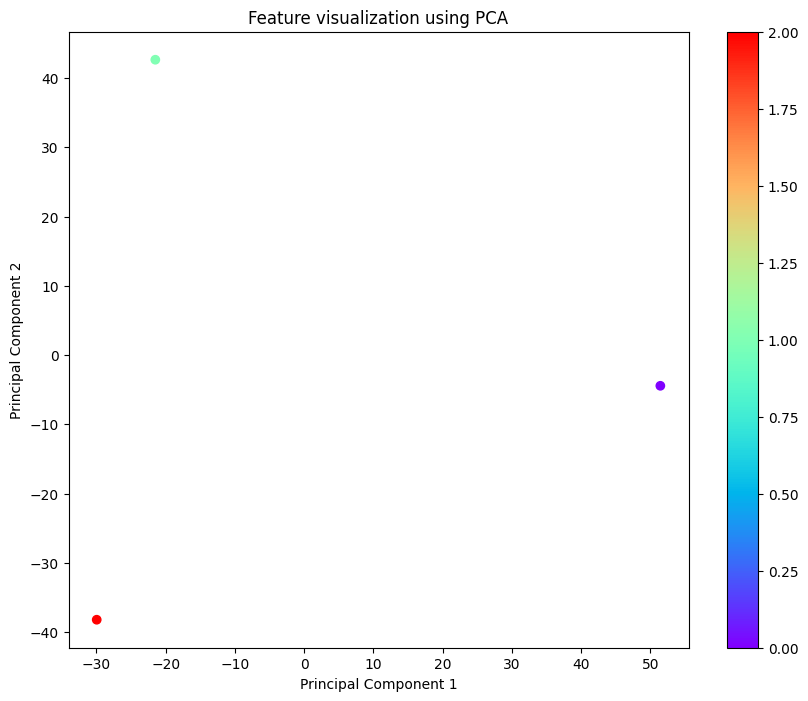

In [13]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numbers
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(labels)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_flattened)

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features_scaled)

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c=y_numeric[:3], cmap='rainbow')
plt.title("Feature visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()



**6. Splitting the Dataset**

In [14]:
print("Shape of reduced_features_pca:", reduced_features_pca.shape)
print("Unique values in y_numeric:", np.unique(y_numeric))


Shape of reduced_features_pca: (3, 2)
Unique values in y_numeric: [0 1 2 3]


In [15]:


# Ensure the number of features matches the number of labels
if len(features_flattened) != len(labels):
    min_len = min(len(features_flattened), len(labels))
    features_flattened = features_flattened[:min_len]
    labels = labels[:min_len]


# Convert string labels to numbers
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(labels)



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_flattened, y_numeric, test_size=0.2, random_state=42)




# Flatten the training and testing features

X_train_flat = flatten_features(X_train)
X_test_flat = flatten_features(X_test)




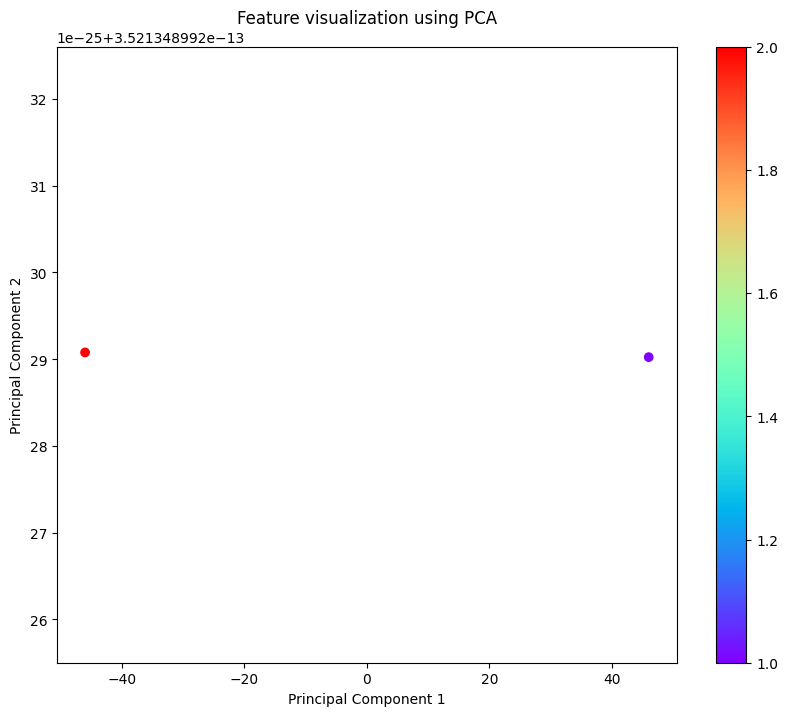

In [16]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c=y_train, cmap='rainbow')
plt.title("Feature visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()


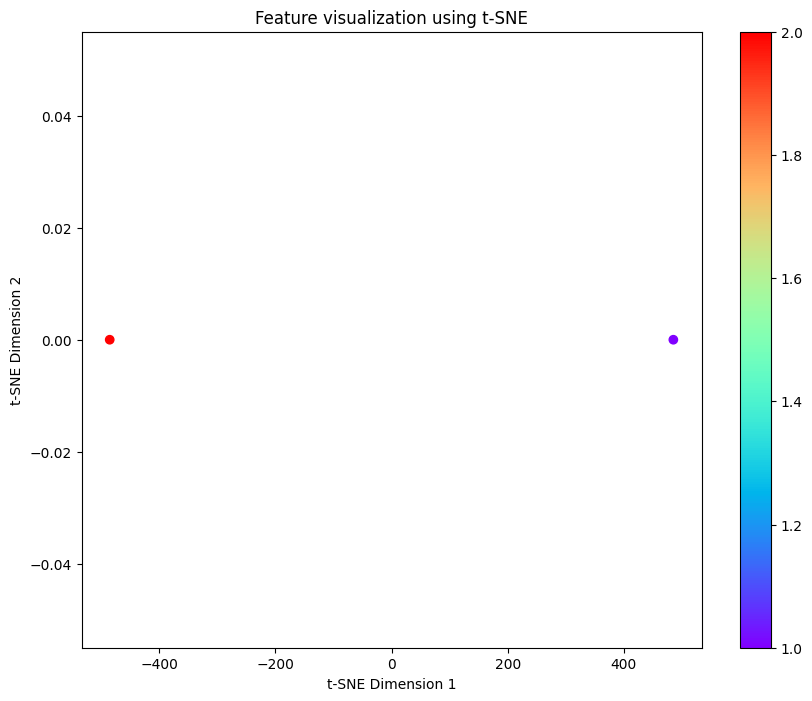

In [17]:
from sklearn.manifold import TSNE
# Apply t-SNE with a lower perplexity value
perplexity_value = min(5, X_train_scaled.shape[0] - 1)  # Taking 5 or one less than the number of samples, whichever is smaller
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
reduced_features_tsne = tsne.fit_transform(X_train_scaled)


plt.figure(figsize=(10, 8))
plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=y_train, cmap='rainbow')
plt.title("Feature visualization using t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar()
plt.show()


## 4. Model Training with SVM

Once we have our features, we'll use them to train a classifier. In this case, we're using a Support Vector Machine (SVM). SVM tries to find a hyperplane in a N-dimensional space that distinctly classifies the data points.

In [24]:



def train_svm(features, labels):

    # Initialize the SVM model with a linear kernel
    model = SVC(kernel='linear', probability=True)

    # Fit (train) the model on the provided features and labels

    model.fit(features, labels)


    return model




In [19]:
# ####  model.fit(features_flattened, labels)

# Train the SVM model using flattened training features
model = train_svm(X_train_scaled, y_train)

In [20]:
# print(X_train_flat[:5])  #  first 5 entries
# print(y_train[:5])

# print(X_train_scaled[:5])

## 5. Evaluation

After training, it's essential to evaluate our model's performance on unseen data. We'll split our dataset into training and testing sets and evaluate the model's accuracy on the test set.

In [21]:
def evaluate_model(model, X_test, y_test):
    # Predict the labels for the test set and calculate the accuracy.
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)